In [59]:
cat('Last updated ', date())

Last updated  Tue Oct 18 15:42:21 2022

In [60]:
R.version

               _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          4                           
minor          1.3                         
year           2022                        
month          03                          
day            10                          
svn rev        81868                       
language       R                           
version.string R version 4.1.3 (2022-03-10)
nickname       One Push-Up                 

In [61]:
setwd('C:/Users/shims/Desktop/TImeSeries')

### The data “gdp.txt” consists of U.S. quarterly real GDP from 1947 to the 2nd quarter of 2005. The data are seasonally adjusted. [There are four columns in the file; year, month, day and GDP.] Build an adequate model for the data, including model checking and outlier detection. Produce 1- to 5-step ahead forecasts at the forecast origin July 2005 (i.e. the last data point).


#### Step1. Draw time series plot

We can investigate the data whether it has any pattern or unusual observation. This time-series data, named _gdp_, does not have an outlier deviating from a time series plot. However, the data has a trend. This is obvious that the data is not stationary, and we might need transformation or differencing the data.   

In [62]:
gdp_data <-read.delim("gdp.txt", sep = "", header = FALSE)

In [63]:
colnames(gdp_data) <- c("Year","Month", "Day", "GDP")

In [64]:
head(gdp_data)

,Year,Month,Day,GDP
,<int>,<int>,<int>,<dbl>
1,1947,1,1,237.2
2,1947,4,1,240.5
3,1947,7,1,244.6
4,1947,10,1,254.4
5,1948,1,1,260.4
6,1948,4,1,267.3


In [65]:
gdp <-gdp_data$GDP
length(gdp)

[1] 235

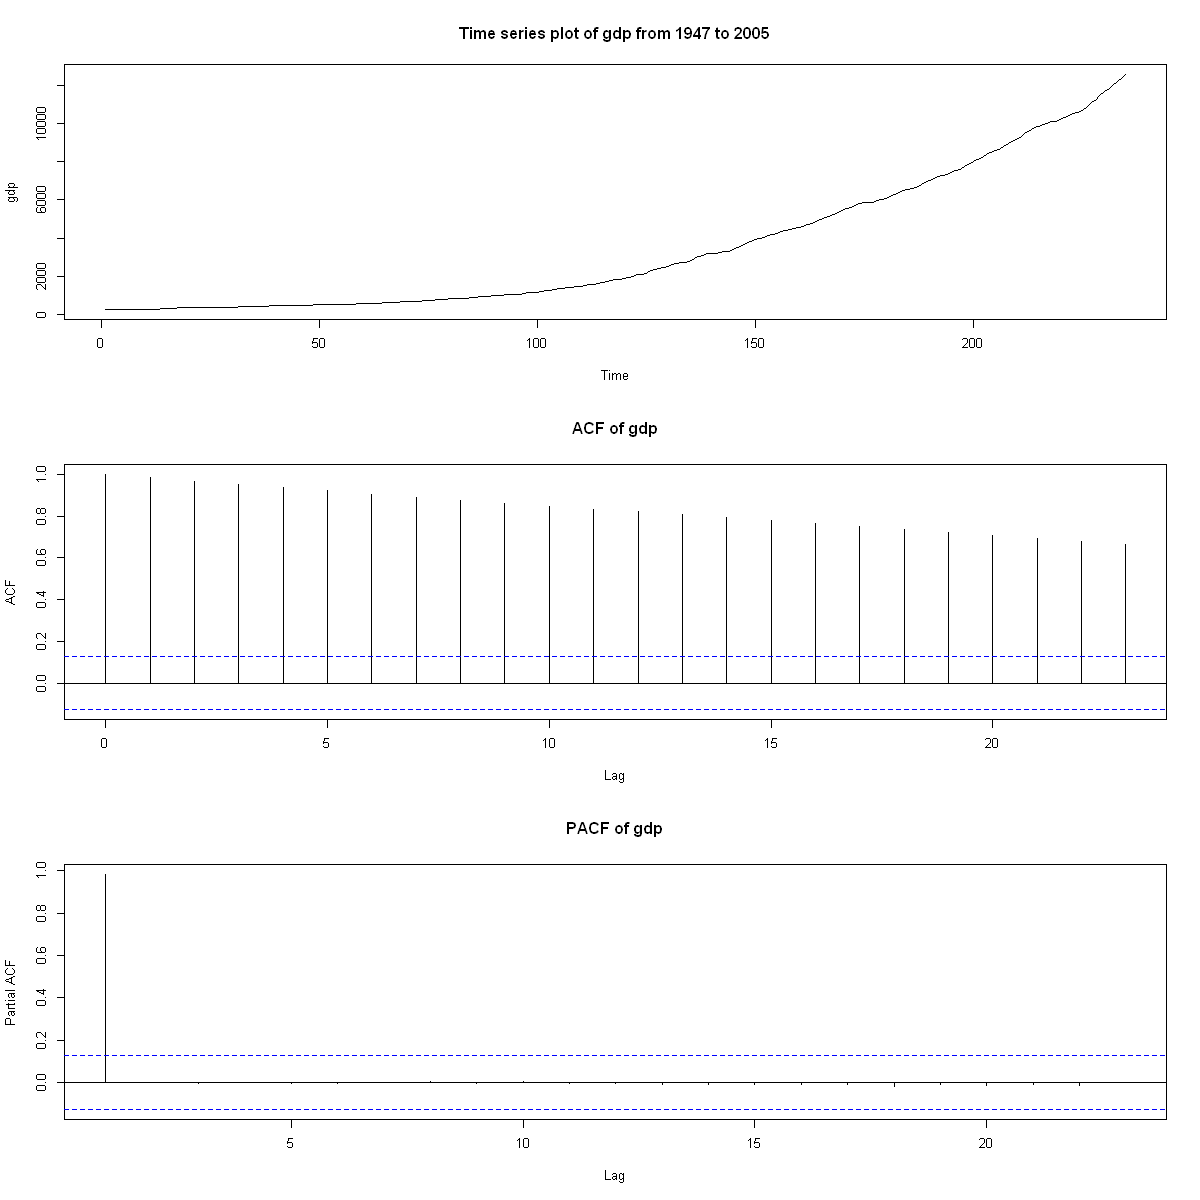

In [66]:
#ts.plot
options(repr.plot.width=10, repr.plot.height=10)
par(mfrow=c(3,1))
ts.plot(gdp, main="Time series plot of gdp from 1947 to 2005")
acf(gdp, main="ACF of gdp")
pacf(gdp, main="PACF of gdp")

#### Step2. Transformation

We consider the three different transformations. First transformation is the logarithm of the gdp since GPD is exponentially growing. Thus, the difference between ln (gdp) will give a clear growth rate. 

1. __ln(gpd)__: logarithm of the gdp
    * Formula: $ln(gdp)$


2. __diff1_ln(gdp)__: $1^{st}$ order differencing the $ln(gdp)$
    * Formula: $ln⁡(gdp_t)-ln⁡(gdp_{t-1})$
    
    
3. __diff2_ln(gdp)__: $2^{nd}$ order differencing the $ln(gdp)$
    * Formula: diff1_$ln⁡(gdp_t)-$diff1_$ln⁡(gdp_{t-1})$

We investigate the possible transformation by time-series plot, ACF, PACF, and Dickey–Fuller Test. As a result, 3.diff2_ln(gdp) satisfies the time series stationarity. Thus, we use model 3 to fit a model. See the following results for details. 

In [67]:
# install.packages('tseries')

In [68]:
library(tseries)

__1.ln(gdp)__ is not stationary. 


	Augmented Dickey-Fuller Test

data:  ln_gdp
Dickey-Fuller = -1.7071, Lag order = 15, p-value = 0.699
alternative hypothesis: stationary


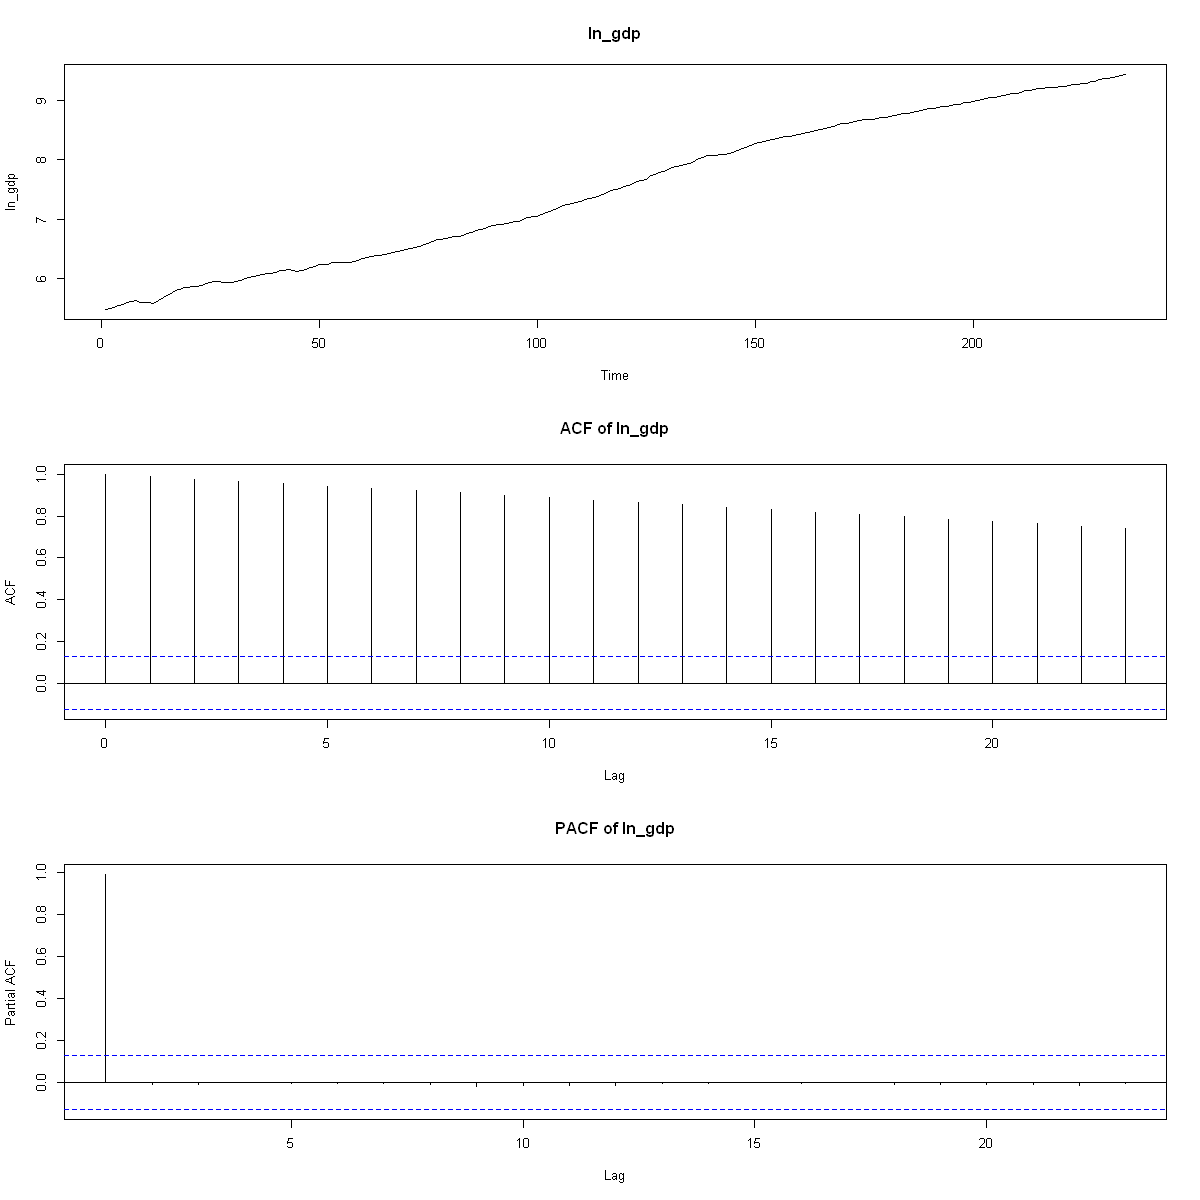

In [69]:
#ln gdp
ln_gdp <-log(gdp)
par(mfrow=c(3,1))
ts.plot(ln_gdp, main="ln_gdp")
acf(ln_gdp,  main="ACF of ln_gdp")
pacf(ln_gdp, main="PACF of ln_gdp")
tseries::adf.test(ln_gdp,k=15, alternative="stationary")

__2.diff1_ln(gdp)__ is also not stationary


	Augmented Dickey-Fuller Test

data:  diff1_ln_gdp
Dickey-Fuller = -2.0053, Lag order = 15, p-value = 0.5737
alternative hypothesis: stationary


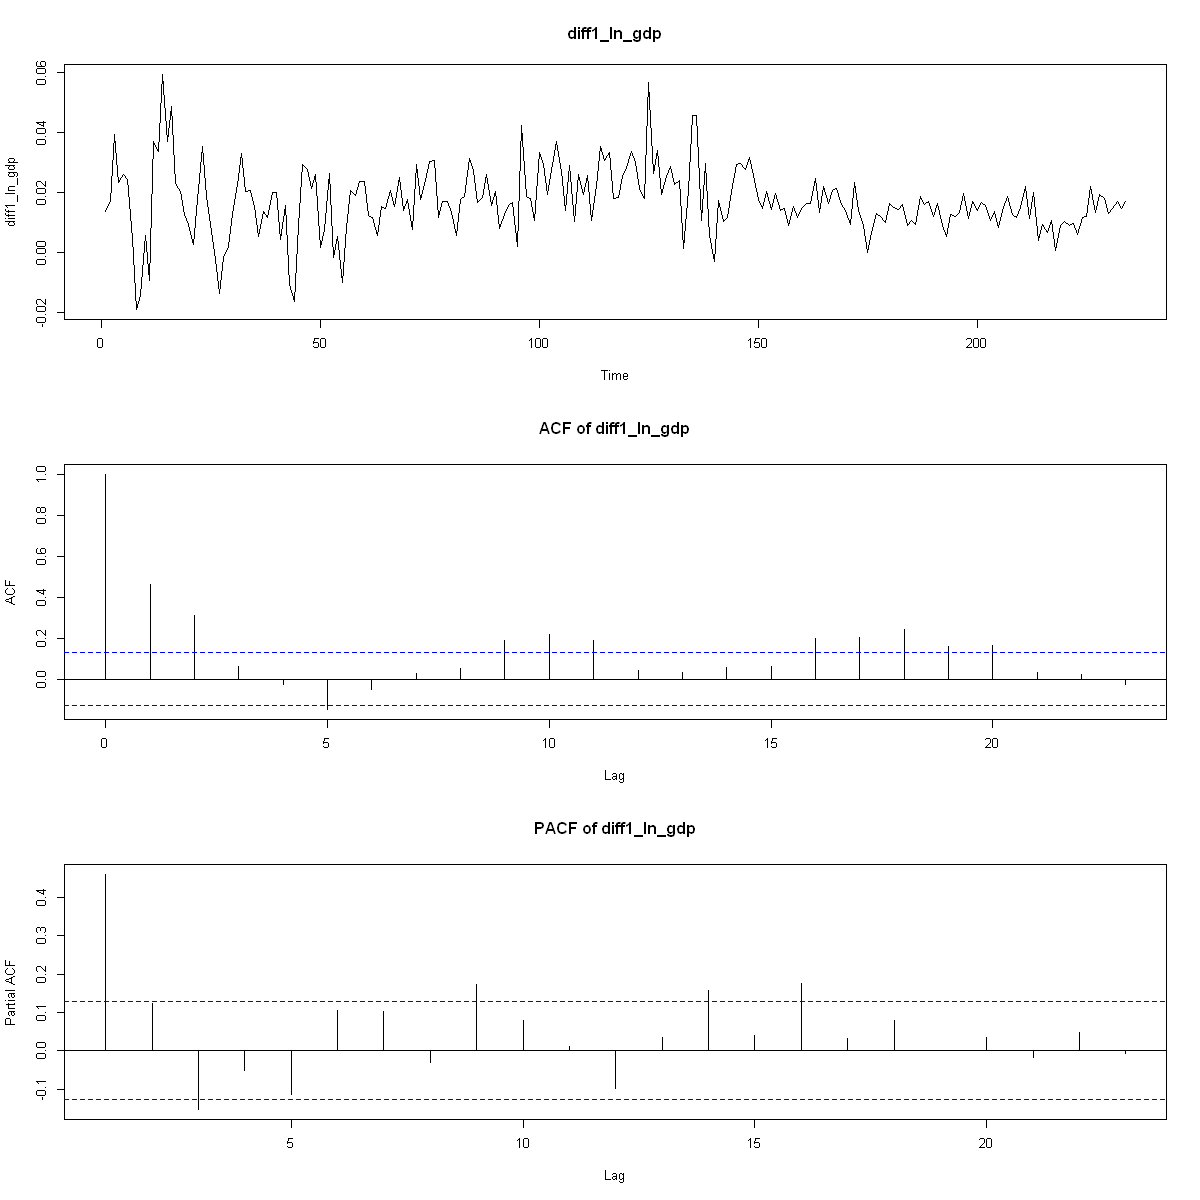

In [70]:
#diff1_ln_gdp
diff1_ln_gdp <-diff(ln_gdp)
par(mfrow=c(3,1))
ts.plot(diff1_ln_gdp, main="diff1_ln_gdp")
acf(diff1_ln_gdp,  main="ACF of diff1_ln_gdp")
pacf(diff1_ln_gdp, main="PACF of diff1_ln_gdp")
adf.test(diff1_ln_gdp,k=15, alternative="stationary")


__3.diff2_ln_gdp is stationary.__

The diff2_ln(gdp), 2nd order differencing of ln(gdp), seems to be stationary since the time series plot does not have a trend and ACF is decreasing. <br>This is confirmed by the Dickey–Fuller Test ($H_0$: non-stationary,$H_1$:stationay) at $\alpha$ level 0.05 since we reject the null hypothesis based on p-value=0.01< 0.05.

Warning message in adf.test(diff2_ln_gdp, k = 15, alternative = "stationary"):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  diff2_ln_gdp
Dickey-Fuller = -7.4245, Lag order = 15, p-value = 0.01
alternative hypothesis: stationary


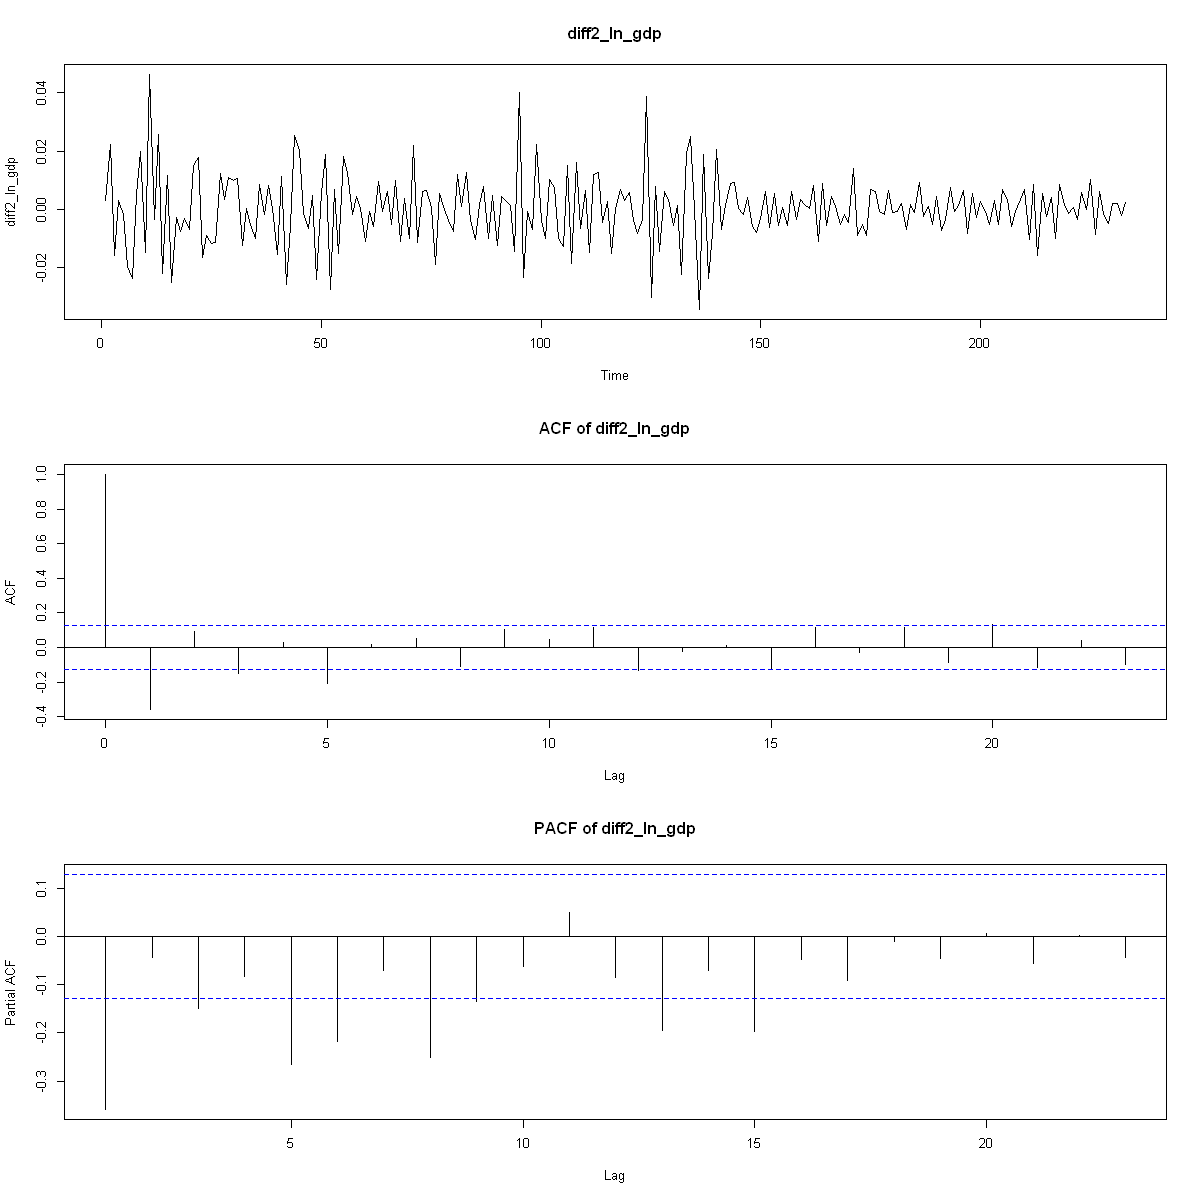

In [71]:
#diff2_ln_gdp
diff2_ln_gdp <-diff(diff1_ln_gdp)
par(mfrow=c(3,1))
ts.plot(diff2_ln_gdp, main="diff2_ln_gdp")
acf(diff2_ln_gdp,  main="ACF of diff2_ln_gdp")
pacf(diff2_ln_gdp, main="PACF of diff2_ln_gdp")
adf.test(diff2_ln_gdp,k=15, alternative="stationary")

#### Step3. Fit a model

In this step, we fit a ARMA model. Since the data are seasonally adjusted, we do not consider seasonal ARMA model. To find the order of ARMA(p,q), auto.arima function in R is used.  ARMA(0,3) has been decided. Next step is to check whether the residual is independent. 

In [72]:
# install.packages('forecast')

In [73]:
library(forecast)

In [74]:
#diff2_ln_gdp
###auto.arima
forecast::auto.arima(diff2_ln_gdp)

Series: diff2_ln_gdp 
ARIMA(0,0,3) with zero mean 

Coefficients:
          ma1      ma2      ma3
      -0.5910  -0.1008  -0.2384
s.e.   0.0655   0.0761   0.0542

sigma^2 = 9.783e-05:  log likelihood = 745.57
AIC=-1483.15   AICc=-1482.97   BIC=-1469.34

#### Step4. Residual independence check

$H_0:\{\epsilon_t\}$is a white noise process. <br>
__diff2_ln(gdp)__  ~ ARMA(0,3)=MA(3) has a white noise process by Box-Pierce test since its p-value=0.0056 is less than the $\alpha$ level at 0.05.  Therefore, the finalized model is __diff2_ln(gdp)__  ~ MA(3) with coefficients $\theta= (-0.5915, -0.1010, -0.2385)$


Series: diff2_ln_gdp 
ARIMA(0,0,3) with non-zero mean 

Coefficients:
          ma1      ma2      ma3   mean
      -0.5915  -0.1010  -0.2385  0e+00
s.e.   0.0655   0.0762   0.0542  1e-04

sigma^2 = 9.821e-05:  log likelihood = 745.61
AIC=-1481.23   AICc=-1480.96   BIC=-1463.97


	Box-Pierce test

data:  res1
X-squared = 27.986, df = 12, p-value = 0.005557


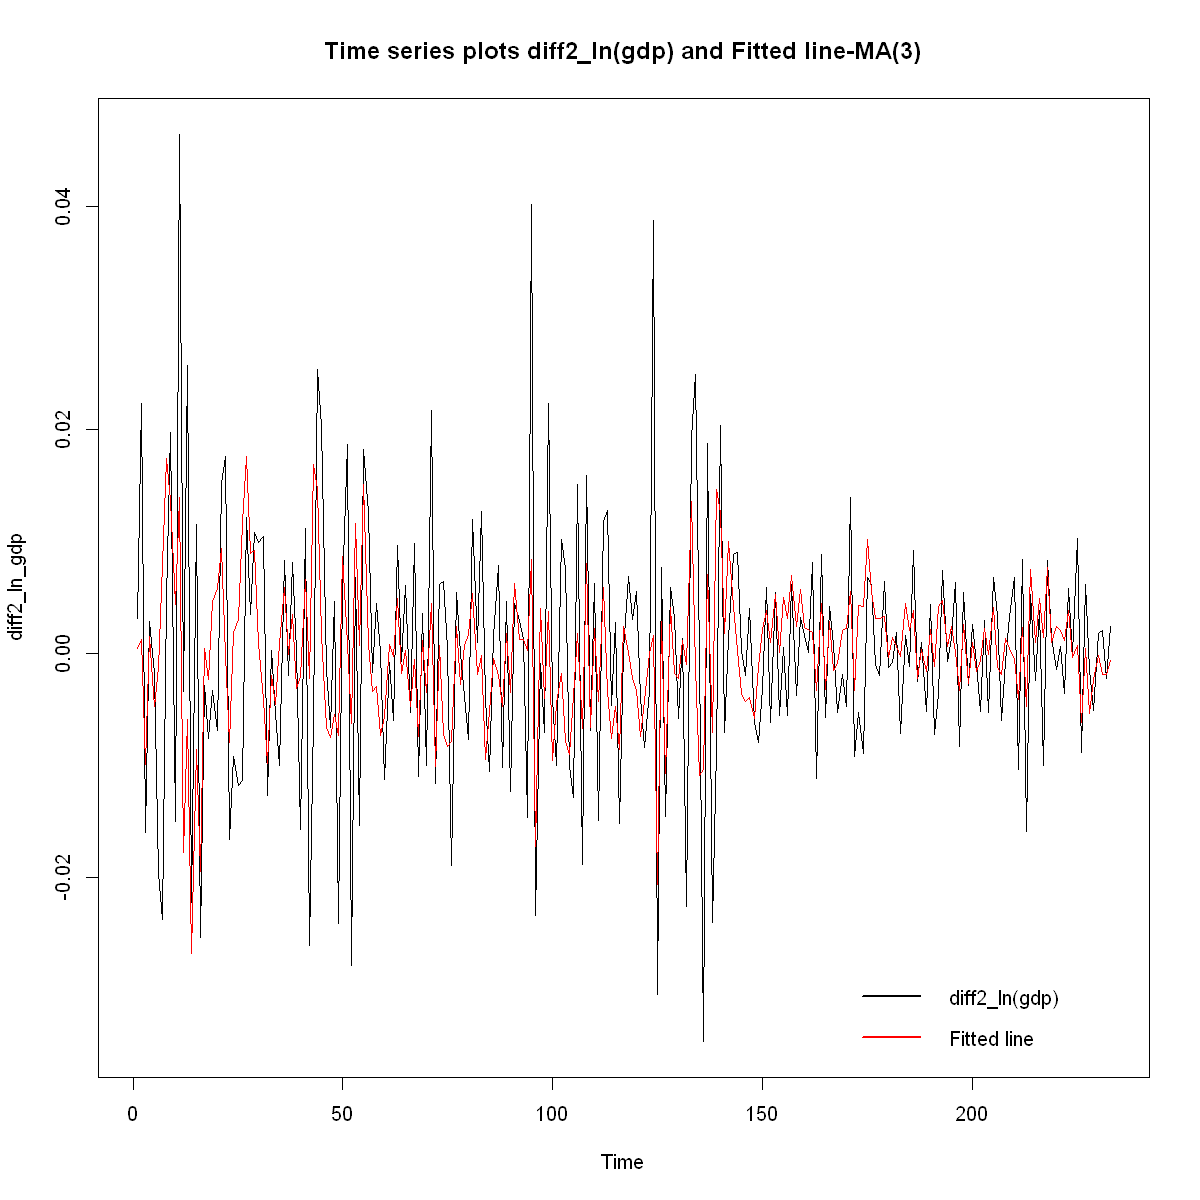

In [75]:
#diff2_ln_gdp
fit1 <-Arima(diff2_ln_gdp, order=c(0,0,3))
fit1

res1=residuals(fit1)
Box.test(res1, lag = 15, type = c("Box-Pierce"), fitdf =3)

ts.plot(diff2_ln_gdp, main="Time series plots diff2_ln(gdp) and Fitted line-MA(3)")
points(fit1$fitted,col = 'red', type = 'l')

legend("bottomright", c("diff2_ln(gdp)","Fitted line"), col = c("black", "red")
       ,inset = c(0,0), lty = c(1,1,0),bty="n", cex = 1, lwd = 2 )

#### Step5. 1 to 5 steps ahead forecast. 

We use the forecast function in the forecast package (forecast::forecast) is R. 

    Point Forecast       Lo 95      Hi 95
234  -2.675157e-03 -0.02209906 0.01674874
235  -2.225286e-04 -0.02278993 0.02234487
236  -7.309789e-04 -0.02338354 0.02192158
237  -1.398911e-05 -0.02313554 0.02310756
238  -1.398911e-05 -0.02313554 0.02310756

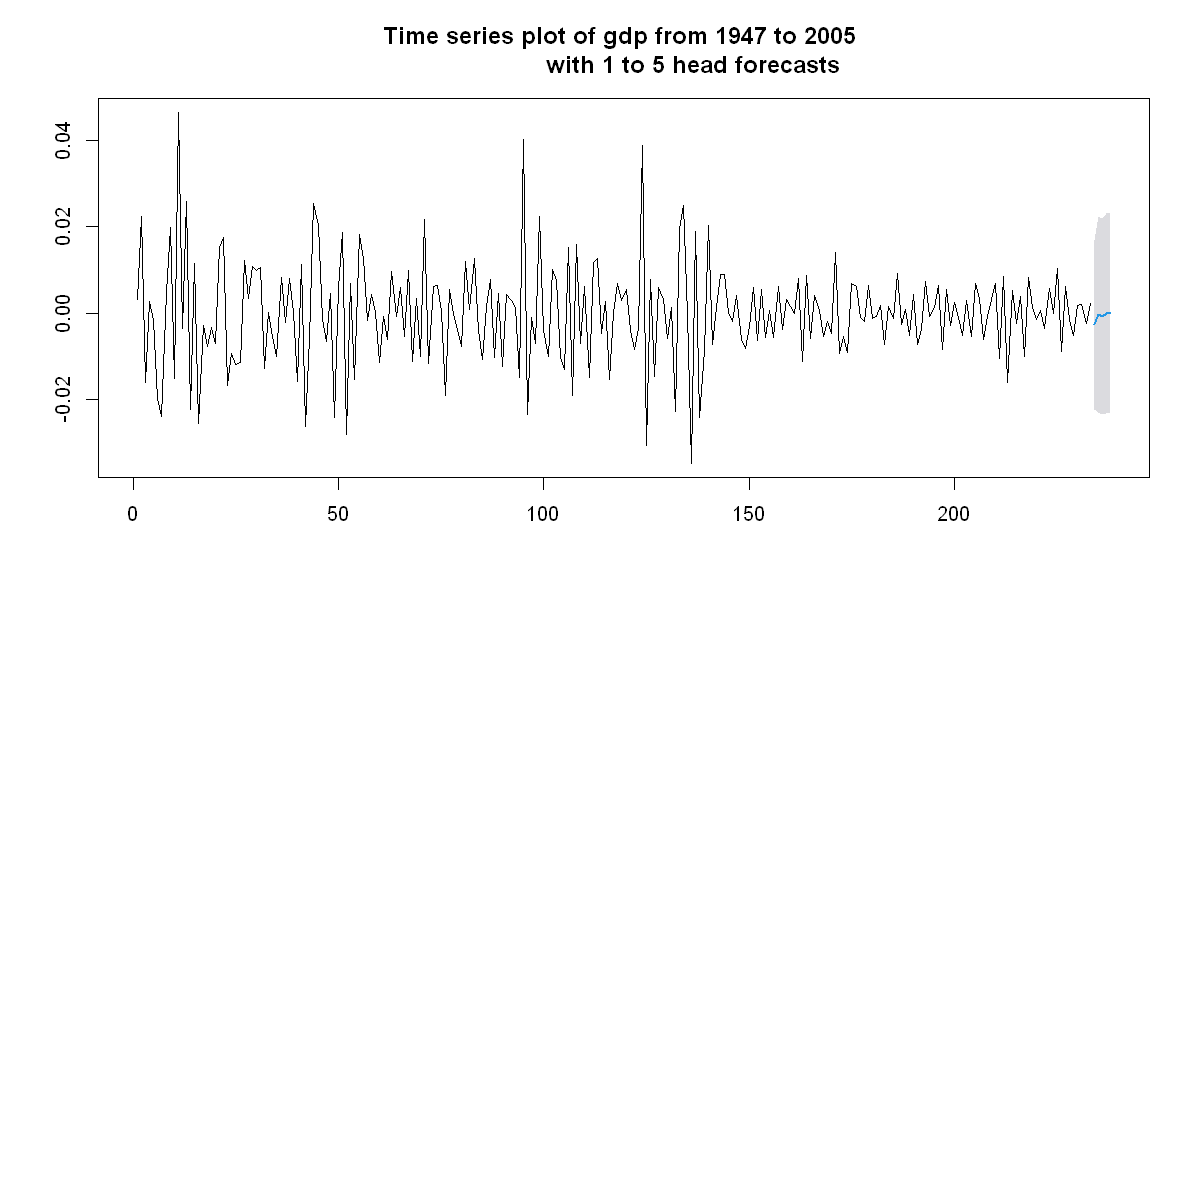

In [76]:
#diff2_ln_gdp
forecast1 <- forecast(fit1, level=c(95), h=5)
forecast1
par(mfrow=c(2,1))
plot(forecast1,main='Time series plot of gdp from 1947 to 2005 
                    with 1 to 5 head forecasts')

#### Step6. De-transformation

The point-forecast is for diff2_ln(gdp), so we need to de-transform the value to the gdp.

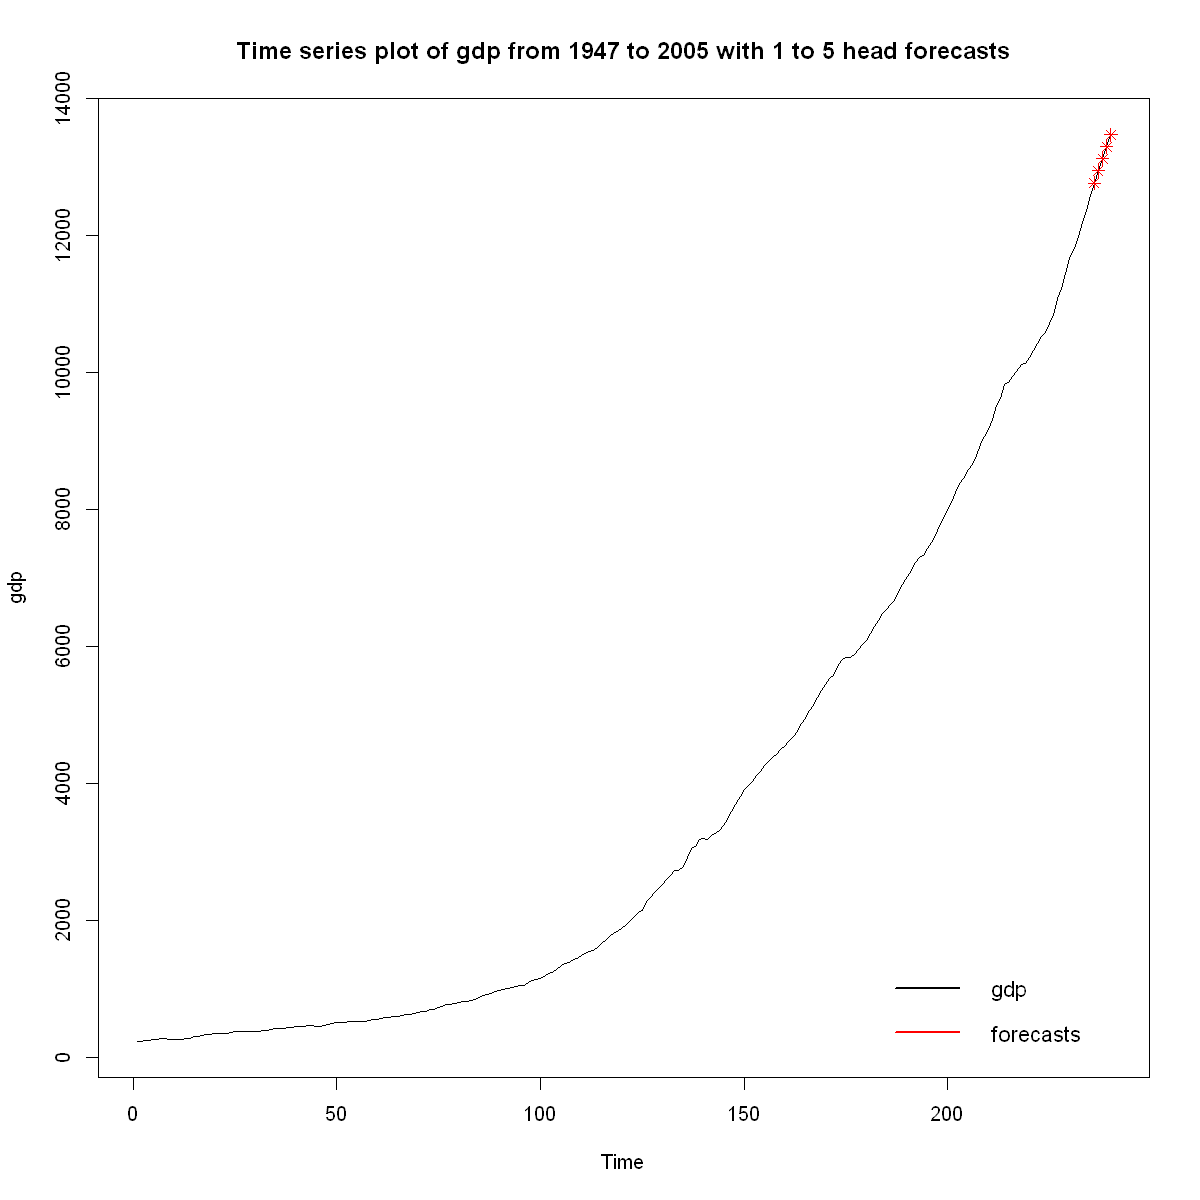

In [77]:
#Combine diff2_ln_gdp and forecasts
forecast_value1<-data.frame(forecast1$mean[1:5])
colnames(forecast_value1)<-"value"

diff2_ln_gdp<-data.frame(diff2_ln_gdp)
colnames(diff2_ln_gdp)<-"value"
total1 <- rbind(diff2_ln_gdp, forecast_value1)

#De-transform to diff1_ln_gdp
detrans_to_diff1_gdp<-c()
cumsum1_gdp<-cumsum(total1)

for (i in 1:dim(total1)[1]+1)
{
  detrans_to_diff1_gdp[1]=diff1_ln_gdp[1]
  if (i>1)
  {detrans_to_diff1_gdp[i]=diff1_ln_gdp[1]+cumsum1_gdp[i-1,]}
}
detrans_to_diff1_gdp<-data.frame(detrans_to_diff1_gdp)

#De-transform to ln_gdp
detrans_to_ln_gdp<-c()
cumsum2_gdp<-cumsum(detrans_to_diff1_gdp)

for (i in 1:dim(cumsum2_gdp)[1]+1)
{
  detrans_to_ln_gdp[1]=ln_gdp[1]
  if (i>1)
  {detrans_to_ln_gdp[i]=ln_gdp[1]+cumsum2_gdp[i-1,]}
}

detrans_to_ln_gdp<-data.frame(detrans_to_ln_gdp)

#De-transform to gdp
detrans_to_gdp<-data.frame(exp(detrans_to_ln_gdp))

ts.plot(detrans_to_gdp, main='Time series plot of gdp from 1947 to 2005 with 1 to 5 head forecasts', col="black", ylab="gdp")

points(x=c(236,237,238,239,240),
       y=c(12770.61,12951.34,13125.02,13300.86,13478.85)
       ,col="red", pch = 8)

legend("bottomright", c("gdp","forecasts"), col = c("black", "red")
       ,inset = c(0,0), lty=c(1,1),bty="n", cex = 1.1, lwd = 2 )